# Autoencoders

> Final project as a Deep Learning for Computer Vision class requirement &#128187;

Jesús E. Hermosilla D.

### Contents

0. Introduction
1. Hyperparameter Search
2. Deep Autoencoders
3. Sparse Autoencoders
4. Denoising Autoencoders
5. Anomaly Detection

## Introduction

Autoencoders (AEs) were first proposed by Rumelhart in 1986. These neural networks are specifically built to learn representations of input data and accurately reconstruct it. AEs work by compressing the input into a concise, meaningful representation and then decoding it to recreate the original data. Classical AEs generally comprises an input layer, a single hidden layers, and an output layer; however, this is not a requirement. In other hand, stacked AEs (or deep AEs), contains multiple hidden layers.

<center>
<img width="278" height="292" src="images/structure.png"/>
</center> 

### References

- Berahmand, K., Daneshfar, F., Salehi, E. S., Li, Y., & Xu, Y. (2024). Autoencoders and their applications in machine learning: a survey. Artificial Intelligence Review, 57(2), 28.
- Boehmke, B., & Greenwell, B. M. (2019). Hands-on machine learning with R. Chapman and Hall/CRC.
- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. nature, 323(6088), 533-536.

In [8]:
"""
Libraries
"""

import time
import torch
import torch.nn as nn
import skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.special import kl_div
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "150%"), ("color", 'black')])]

In [9]:
"""
Hyperparameters
"""

learning_rate_   = 0.001
batch_size_      = 64
num_epochs_      = 15
input_dimension_ = 32*32*3
laten_dimension_ = 256
encoder_neurons_ = 1024
decoder_neurons_ = 256

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

In [60]:
"""
Loading datasets
"""

# Cifar 10
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_, shuffle=True)
features = torch.stack([train_set[i][0].view(-1) for i in range(len(train_set))]).numpy()
targets = features

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_, shuffle=True)

# Cifar 100
train_set2 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=batch_size_, shuffle=True)
features2 = torch.stack([train_set2[i][0].view(-1) for i in range(len(train_set2))]).numpy()
targets2 = features2

test_set2 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=batch_size_, shuffle=True)

# SBU
train_set3 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader3 = torch.utils.data.DataLoader(train_set2, batch_size=batch_size_, shuffle=True)
features3 = torch.stack([train_set3[i][0].view(-1) for i in range(len(train_set3))]).numpy()
targets3 = features3

test_set3 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_loader3 = torch.utils.data.DataLoader(test_set3, batch_size=batch_size_, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Architecture

In [11]:
"""
    Args:
        input_dim (int): The size of the input data (height*width*channels).
        latent_dim (int): The size of the latent space.
        encoder_neurons (int): Number of neurons in the first encoder layer.
        decoder_neurons (int): Number of neurons in the first decoder layer.
"""

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_neurons, decoder_neurons):
        super(Autoencoder, self).__init__()
        # Encoder: Compresses image to a latent representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoder_neurons),
            nn.ReLU(),
            nn.Linear(encoder_neurons, decoder_neurons),
            nn.ReLU(),
            nn.Linear(decoder_neurons, latent_dim),
            nn.ReLU(),
        )
        # Decoder: Reconstructs image from the latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, decoder_neurons),
            nn.ReLU(),
            nn.Linear(decoder_neurons, encoder_neurons),
            nn.ReLU(),
            nn.Linear(encoder_neurons, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # Pass through encoder
        latent = self.encoder(x)
        self.latent_ = latent
        # Pass through decoder
        reconstructed = self.decoder(latent)
        return reconstructed

## 1. Hyperparameter Search

In [12]:
"""
Creating model container
"""

# Cifar 10
earlystopping = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 10)
AutoencoderModel = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      callbacks = [earlystopping],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.001)

# Cifar 100
earlystopping2 = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 10)
AutoencoderModel2 = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      callbacks = [earlystopping2],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.001)

In [13]:
"""
Applying hyperparameter grid search
"""

GridModel = {'module__encoder_neurons': [1024, 512],
             'module__decoder_neurons': [512, 256],
             'module__latent_dim':      [256, 128],
             'lr':                      [0.001, 0.01]}

# Cifar 10
grid_search = GridSearchCV(AutoencoderModel,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,
                           n_jobs=2,
                           cv=2,                             
                           verbose=1)

# Cifar 100
grid_search2 = GridSearchCV(AutoencoderModel2,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,
                           n_jobs=2,
                           cv=2,                             
                           verbose=1)

In [ ]:
# Cifar 10
start_time = time.time()
grid_result = grid_search.fit(features, targets)
print("%s seconds" % (time.time() - start_time))

In [ ]:
# Cifar 100
start_time2 = time.time()
grid_result2 = grid_search2.fit(features2, targets2)
print("%s seconds" % (time.time() - start_time2))

In [16]:
# Cifar 10
print("Best Cifar 10 Parameters:", grid_result.best_params_)
grid_dict = grid_result.cv_results_

# Cifar 100
print("Best Cifar 100 Parameters:", grid_result.best_params_)
grid_dict2 = grid_result2.cv_results_

Best Cifar 10 Parameters: {'lr': 0.01, 'module__decoder_neurons': 256, 'module__encoder_neurons': 1024, 'module__latent_dim': 128}
Best Cifar 100 Parameters: {'lr': 0.01, 'module__decoder_neurons': 256, 'module__encoder_neurons': 1024, 'module__latent_dim': 128}


In [17]:
# Cifar 10
grid_df = pd.DataFrame({'param_lr': grid_dict['param_lr'],
              'param_module__latent_dim': grid_dict['param_module__latent_dim'],
              'param_module__encoder_neurons': grid_dict['param_module__encoder_neurons'],
              'param_module__decoder_neurons': grid_dict['param_module__decoder_neurons'],
              'mean_test_score': -grid_dict['mean_test_score'],
              'std_test_score': grid_dict['std_test_score']},
              index=pd.Index(grid_dict['rank_test_score'], name='rank_test_score'))
grid_df = grid_df.style.set_caption("Architectures resulting from Cifar 10").set_table_styles(styles)
grid_df

,param_lr,param_module__latent_dim,param_module__encoder_neurons,param_module__decoder_neurons,mean_test_score,std_test_score
rank_test_score,,,,,,
5,0.001000,256,1024,512,0.064024,0.000271
7,0.001000,128,1024,512,0.064032,0.000267
14,0.001000,256,512,512,0.064052,0.000262
4,0.001000,128,512,512,0.064021,0.000262
8,0.001000,256,1024,256,0.064034,0.000277
10,0.001000,128,1024,256,0.064036,0.000265
16,0.001000,256,512,256,0.064057,0.000276
15,0.001000,128,512,256,0.064056,0.000268
6,0.010000,256,1024,512,0.064025,0.000277


In [18]:
# Cifar 100
grid_df2 = pd.DataFrame({'param_lr': grid_dict2['param_lr'],
              'param_module__latent_dim': grid_dict2['param_module__latent_dim'],
              'param_module__encoder_neurons': grid_dict2['param_module__encoder_neurons'],
              'param_module__decoder_neurons': grid_dict2['param_module__decoder_neurons'],
              'mean_test_score': -grid_dict2['mean_test_score'],
              'std_test_score': grid_dict2['std_test_score']},
              index=pd.Index(grid_dict2['rank_test_score'], name='rank_test_score'))
grid_df2 = grid_df2.style.set_caption("Architectures resulting from Cifar 100").set_table_styles(styles)
grid_df2

,param_lr,param_module__latent_dim,param_module__encoder_neurons,param_module__decoder_neurons,mean_test_score,std_test_score
rank_test_score,,,,,,
5,0.001000,256,1024,512,0.072427,0.000006
6,0.001000,128,1024,512,0.072428,0.000008
15,0.001000,256,512,512,0.072464,0.000015
13,0.001000,128,512,512,0.072462,0.000001
11,0.001000,256,1024,256,0.072446,0.000012
10,0.001000,128,1024,256,0.072443,0.000009
14,0.001000,256,512,256,0.072462,0.000027
16,0.001000,128,512,256,0.072481,0.000004
2,0.010000,256,1024,512,0.072411,0.000002


## 2. Deep Autoencoders

In [64]:
# Cifar 10
model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
model.to(dev)

# Cifar 100
model2 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
model2.to(dev)

# SBU
model3 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
model3.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [65]:
# Cifar 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate_,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

# Cifar 100
criterion2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(),
                             lr=learning_rate_,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

# SBU
criterion3 = nn.MSELoss()
optimizer3 = torch.optim.Adam(model3.parameters(),
                             lr=learning_rate_,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

Epoch [1/15], Loss: 0.0296
Epoch [2/15], Loss: 0.0221
Epoch [3/15], Loss: 0.0191
Epoch [4/15], Loss: 0.0172
Epoch [5/15], Loss: 0.0162
Epoch [6/15], Loss: 0.0154
Epoch [7/15], Loss: 0.0146
Epoch [8/15], Loss: 0.0140
Epoch [9/15], Loss: 0.0137
Epoch [10/15], Loss: 0.0134
Epoch [11/15], Loss: 0.0129
Epoch [12/15], Loss: 0.0125
Epoch [13/15], Loss: 0.0124
Epoch [14/15], Loss: 0.0123
Epoch [15/15], Loss: 0.0121


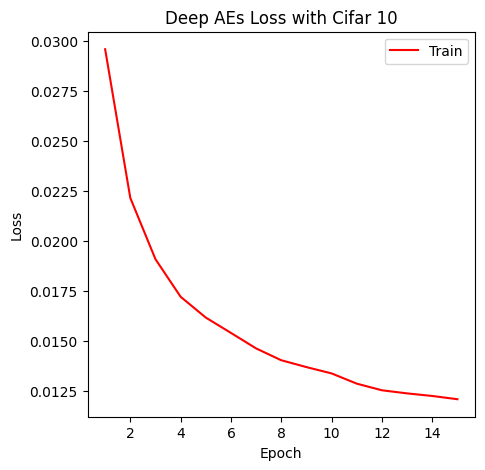

In [21]:
# Cifar 10
deep_loss_hist = []
for epoch in range(num_epochs_):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer.zero_grad()
        outputs = model(images)
        flat_images = images.view(images.size(0), -1)
        loss = criterion(outputs, flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")
    deep_loss_hist.append(train_loss)

plt.figure(figsize=(5, 5))
plt.plot(range(1,num_epochs_+1), deep_loss_hist, label='Train', color='red')
plt.title('Deep AEs Loss with Cifar 10')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [1/15], Loss: 0.0296
Epoch [2/15], Loss: 0.0218
Epoch [3/15], Loss: 0.0193
Epoch [4/15], Loss: 0.0171
Epoch [5/15], Loss: 0.0162
Epoch [6/15], Loss: 0.0154
Epoch [7/15], Loss: 0.0148
Epoch [8/15], Loss: 0.0142
Epoch [9/15], Loss: 0.0135
Epoch [10/15], Loss: 0.0131
Epoch [11/15], Loss: 0.0129
Epoch [12/15], Loss: 0.0125
Epoch [13/15], Loss: 0.0123
Epoch [14/15], Loss: 0.0122
Epoch [15/15], Loss: 0.0120


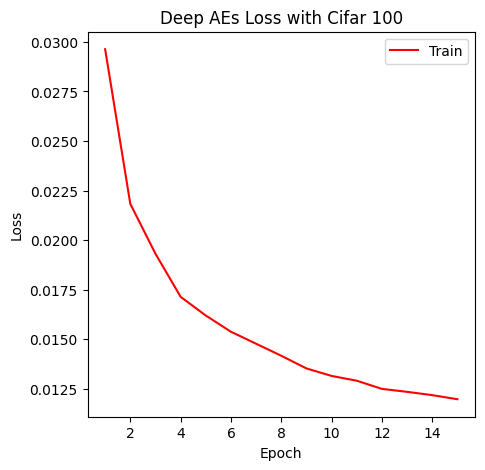

In [22]:
# Cifar 100
deep_loss_hist2 = []
for epoch in range(num_epochs_):
    model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer2.zero_grad()
        outputs = model2(images)
        flat_images = images.view(images.size(0), -1)
        loss2 = criterion2(outputs, flat_images)
        with torch.no_grad():
          train_loss += loss2.item()
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")
    deep_loss_hist2.append(train_loss)

plt.figure(figsize=(5, 5))
plt.plot(range(1,num_epochs_+1), deep_loss_hist2, label='Train', color='red')
plt.title('Deep AEs Loss with Cifar 100')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [1/15], Loss: 0.0300
Epoch [2/15], Loss: 0.0219
Epoch [3/15], Loss: 0.0193
Epoch [4/15], Loss: 0.0171
Epoch [5/15], Loss: 0.0161
Epoch [6/15], Loss: 0.0155
Epoch [7/15], Loss: 0.0147
Epoch [8/15], Loss: 0.0141
Epoch [9/15], Loss: 0.0138
Epoch [10/15], Loss: 0.0132
Epoch [11/15], Loss: 0.0129
Epoch [12/15], Loss: 0.0126
Epoch [13/15], Loss: 0.0125
Epoch [14/15], Loss: 0.0122
Epoch [15/15], Loss: 0.0118


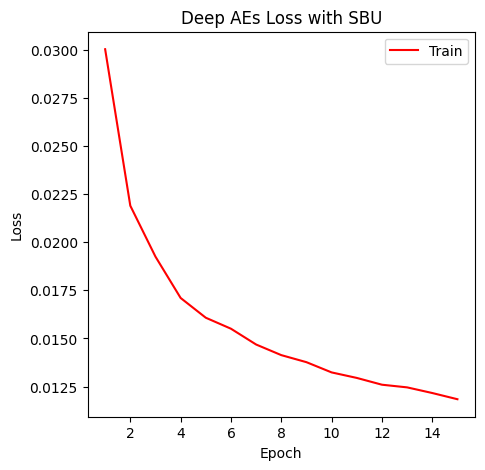

In [66]:
# SBU
deep_loss_hist3 = []
for epoch in range(num_epochs_):
    model3.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer3.zero_grad()
        outputs = model3(images)
        flat_images = images.view(images.size(0), -1)
        loss3 = criterion3(outputs, flat_images)
        with torch.no_grad():
          train_loss += loss3.item()
        optimizer3.zero_grad()
        loss3.backward()
        optimizer3.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")
    deep_loss_hist3.append(train_loss)

plt.figure(figsize=(5, 5))
plt.plot(range(1,num_epochs_+1), deep_loss_hist3, label='Train', color='red')
plt.title('Deep AEs Loss with SBU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 1600x1200 with 0 Axes>

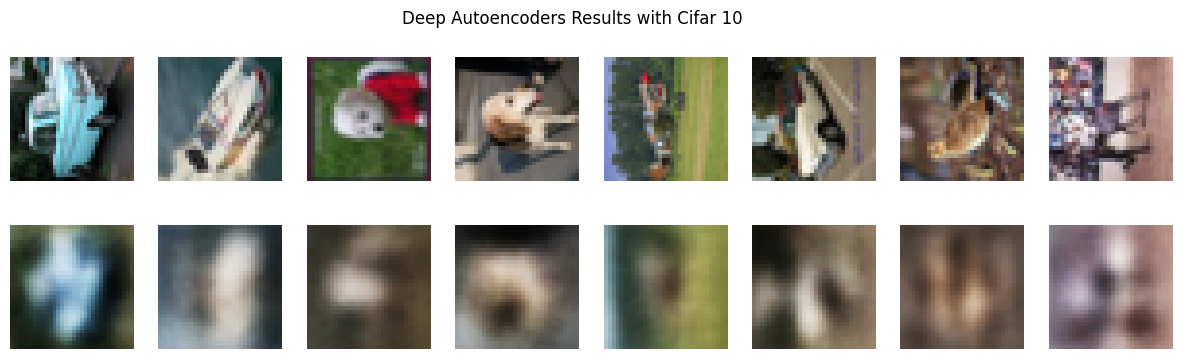

In [23]:
# Cifar 10
with torch.no_grad():
    for data_a, _ in test_loader:
        data_a = data_a.to(dev)
        recon = model(data_a)
        break
recon1 = recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Deep Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_a[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

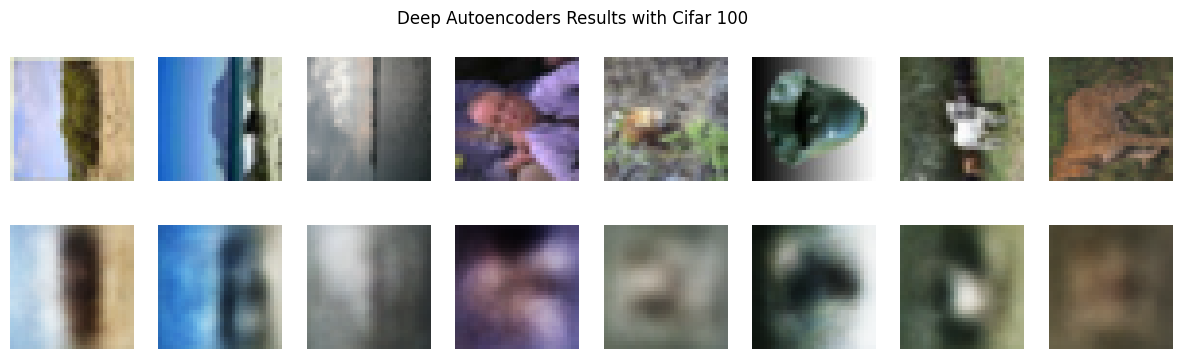

In [54]:
# Cifar 100
with torch.no_grad():
    for data_a, _ in test_loader2:
        data_a = data_a.to(dev)
        recon = model2(data_a)
        break
recon1 = recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Deep Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_a[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

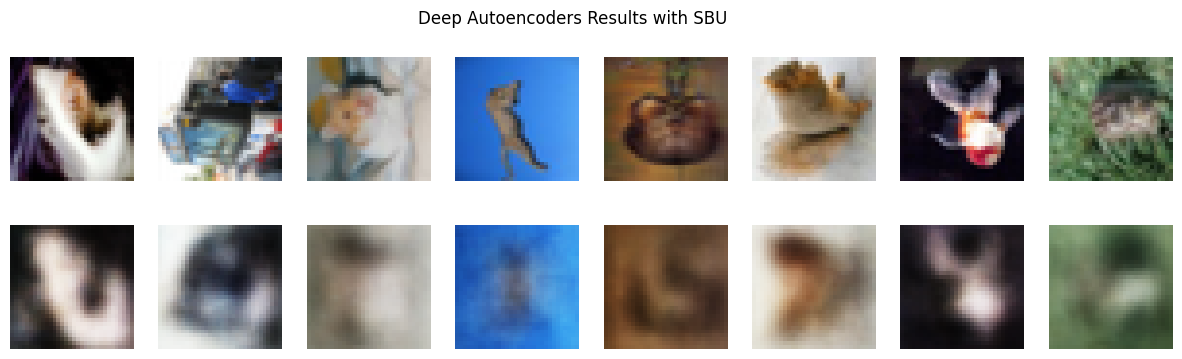

In [70]:
# SBU
with torch.no_grad():
    for data_a, _ in test_loader3:
        data_a = data_a.to(dev)
        recon = model3(data_a)
        break
recon1 = recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Deep Autoencoders Results with SBU')
for i in range(8):
    ax[0, i].imshow(data_a[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 3. Sparse Autoencoders

In [25]:
# Additional hyperparameters
Gridbeta = {'beta': [0.01, 0.05, 0.1, 0.2]}

In [68]:
# Cifar 10
sparse_model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
sparse_model.to(dev)

# Cifar 100
sparse_model2 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
sparse_model2.to(dev)

# SBU
sparse_model3 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
sparse_model3.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [69]:
# Cifar 10
sparse_criterion = nn.MSELoss()
sparse_optimizer = torch.optim.Adam(sparse_model.parameters(),
                                    lr=learning_rate_,
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)

# Cifar 100
sparse_criterion2 = nn.MSELoss()
sparse_optimizer2 = torch.optim.Adam(sparse_model2.parameters(),
                                    lr=learning_rate_,
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)

# SBU
sparse_criterion3 = nn.MSELoss()
sparse_optimizer3 = torch.optim.Adam(sparse_model3.parameters(),
                                    lr=learning_rate_,
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)

In [28]:
# General trainning
def sparse_training(model_, beta):
  for epoch in range(num_epochs_):
      model_.train()
      train_loss = 0.0
      for images, _ in train_loader:
          images = images.to(dev)
          sparse_optimizer.zero_grad()
          outputs = model_(images)
          flat_images = images.view(images.size(0), -1)
          rho_ = torch.mean(model_.latent_).cpu().item()
          sparse_penalty = beta*kl_div(0.05,rho_)
          loss = sparse_criterion(outputs,flat_images) + sparse_penalty
          with torch.no_grad():
            train_loss += loss.item()
          sparse_optimizer.zero_grad()
          loss.backward()
          sparse_optimizer.step()        
      train_loss /= len(train_loader)    
  print("Beta: ", beta, " Done!")
  return train_loss

In [29]:
# Cifar 10 GridSearch
beta_results = []
for b in Gridbeta['beta']:
  b_result = sparse_training(sparse_model, b)
  beta_results.append(b_result)

beta_results = np.array(beta_results)
best_b = np.argmin(beta_results)
beta = Gridbeta['beta'][best_b]

Stopping since train_loss has not improved in the last 10 epochs.
Beta:  0.01  Done!
Beta:  0.05  Done!
Beta:  0.1  Done!
Beta:  0.2  Done!


In [30]:
# Cifar 100 GridSearch
beta_results2 = []
for b in Gridbeta['beta']:
  b_result = sparse_training(sparse_model2, b)
  beta_results2.append(b_result)

beta_results2 = np.array(beta_results2)
best_b2 = np.argmin(beta_results2)
beta2 = Gridbeta['beta'][best_b2]

Beta:  0.01  Done!
Beta:  0.05  Done!
Beta:  0.1  Done!
Beta:  0.2  Done!


In [31]:
# Cifar 10 training
for epoch in range(num_epochs_):
    sparse_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        sparse_optimizer.zero_grad()
        outputs = sparse_model(images)
        flat_images = images.view(images.size(0), -1)
        rho_ = torch.mean(sparse_model.latent_).cpu().item()
        sparse_penalty = beta*kl_div(0.05,rho_)
        loss = sparse_criterion(outputs,flat_images) + sparse_penalty
        with torch.no_grad():
          train_loss += loss.item()
        sparse_optimizer.zero_grad()
        loss.backward()
        sparse_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/15], Loss: 0.0107
Epoch [2/15], Loss: 0.0107
Epoch [3/15], Loss: 0.0107
Epoch [4/15], Loss: 0.0107
Epoch [5/15], Loss: 0.0107
Epoch [6/15], Loss: 0.0106
Epoch [7/15], Loss: 0.0106
Epoch [8/15], Loss: 0.0106
Epoch [9/15], Loss: 0.0106
Epoch [10/15], Loss: 0.0106
Epoch [11/15], Loss: 0.0106
Epoch [12/15], Loss: 0.0106
Epoch [13/15], Loss: 0.0105
Epoch [14/15], Loss: 0.0105
Epoch [15/15], Loss: 0.0105


In [32]:
# Cifar 100 training
for epoch in range(num_epochs_):
    sparse_model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        sparse_optimizer2.zero_grad()
        outputs = sparse_model2(images)
        flat_images = images.view(images.size(0), -1)
        rho_ = torch.mean(sparse_model2.latent_).cpu().item()
        sparse_penalty = beta2*kl_div(0.05,rho_)
        loss2 = sparse_criterion2(outputs,flat_images) + sparse_penalty
        with torch.no_grad():
          train_loss += loss2.item()
        sparse_optimizer2.zero_grad()
        loss2.backward()
        sparse_optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/15], Loss: 0.0302
Epoch [2/15], Loss: 0.0227
Epoch [3/15], Loss: 0.0199
Epoch [4/15], Loss: 0.0178
Epoch [5/15], Loss: 0.0168
Epoch [6/15], Loss: 0.0162
Epoch [7/15], Loss: 0.0157
Epoch [8/15], Loss: 0.0152
Epoch [9/15], Loss: 0.0147
Epoch [10/15], Loss: 0.0145
Epoch [11/15], Loss: 0.0143
Epoch [12/15], Loss: 0.0141
Epoch [13/15], Loss: 0.0137
Epoch [14/15], Loss: 0.0135
Epoch [15/15], Loss: 0.0134


<Figure size 1600x1200 with 0 Axes>

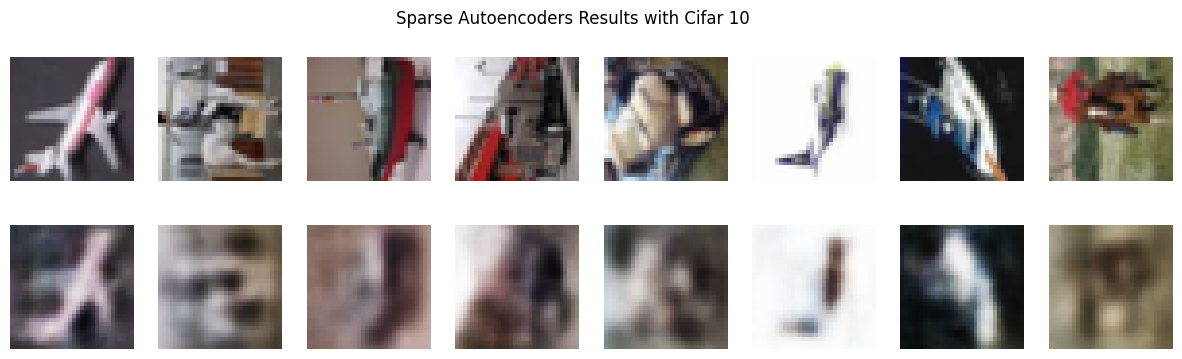

In [33]:
# Cifar 10
with torch.no_grad():
    for data_b, _ in test_loader:
        data_b = data_b.to(dev)
        sparse_recon = sparse_model(data_b)
        break
sparse_recon1 = sparse_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Sparse Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_b[i].cpu().numpy().T)
    ax[1, i].imshow(sparse_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

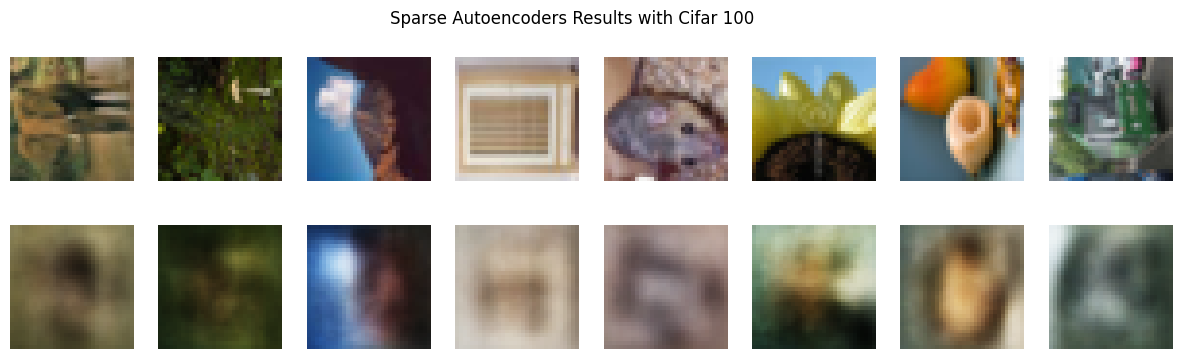

In [55]:
# Cifar 100
with torch.no_grad():
    for data_b, _ in test_loader2:
        data_b = data_b.to(dev)
        sparse_recon = sparse_model2(data_b)
        break
sparse_recon1 = sparse_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Sparse Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_b[i].cpu().numpy().T)
    ax[1, i].imshow(sparse_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 4. Denoising Autoencoders

In [35]:
# Cifar 10
denoising_model = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
denoising_model.to(dev)

# Cifar 100
denoising_model2 = Autoencoder(input_dimension_, laten_dimension_, encoder_neurons_, decoder_neurons_)
denoising_model2.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [36]:
# Cifar 10
denoising_criterion = nn.MSELoss()
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(),
                                       lr=learning_rate_,
                                       betas=(0.9, 0.999),
                                       eps=1e-08,
                                       weight_decay=0,
                                       amsgrad=False)

# Cifar 100
denoising_criterion2 = nn.MSELoss()
denoising_optimizer2 = torch.optim.Adam(denoising_model.parameters(),
                                       lr=learning_rate_,
                                       betas=(0.9, 0.999),
                                       eps=1e-08,
                                       weight_decay=0,
                                       amsgrad=False)

Epoch [1/15], Loss: 0.0384
Epoch [2/15], Loss: 0.0304
Epoch [3/15], Loss: 0.0280
Epoch [4/15], Loss: 0.0257
Epoch [5/15], Loss: 0.0247
Epoch [6/15], Loss: 0.0239
Epoch [7/15], Loss: 0.0233
Epoch [8/15], Loss: 0.0228
Epoch [9/15], Loss: 0.0221
Epoch [10/15], Loss: 0.0218
Epoch [11/15], Loss: 0.0217
Epoch [12/15], Loss: 0.0213
Epoch [13/15], Loss: 0.0211
Epoch [14/15], Loss: 0.0209
Epoch [15/15], Loss: 0.0207


<Figure size 1600x1200 with 0 Axes>

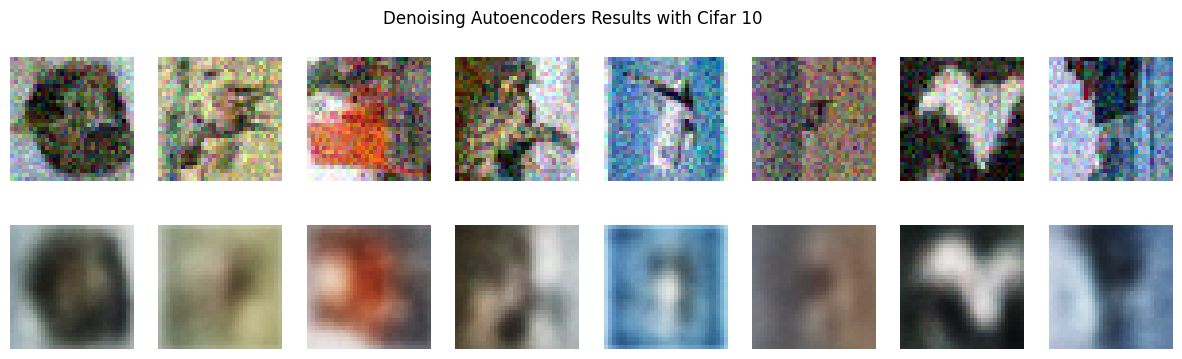

In [37]:
# Cifar 10
noise = 0.1
for epoch in range(num_epochs_):
    denoising_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer.zero_grad()
        outputs = denoising_model(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss = denoising_criterion(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        denoising_optimizer.zero_grad()
        loss.backward()
        denoising_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Epoch [1/15], Loss: 0.0304
Epoch [2/15], Loss: 0.0302
Epoch [3/15], Loss: 0.0301
Epoch [4/15], Loss: 0.0300
Epoch [5/15], Loss: 0.0299
Epoch [6/15], Loss: 0.0297
Epoch [7/15], Loss: 0.0296
Epoch [8/15], Loss: 0.0294
Epoch [9/15], Loss: 0.0293
Epoch [10/15], Loss: 0.0292
Epoch [11/15], Loss: 0.0291
Epoch [12/15], Loss: 0.0291
Epoch [13/15], Loss: 0.0290
Epoch [14/15], Loss: 0.0289
Epoch [15/15], Loss: 0.0288


<Figure size 1600x1200 with 0 Axes>

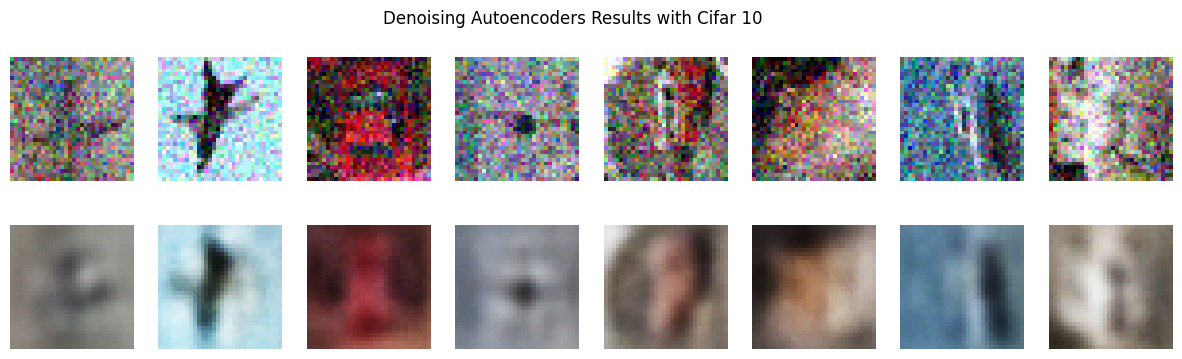

In [38]:
# Cifar 10
noise = 0.15
for epoch in range(num_epochs_):
    denoising_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer.zero_grad()
        outputs = denoising_model(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss = denoising_criterion(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        denoising_optimizer.zero_grad()
        loss.backward()
        denoising_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 10')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Epoch [1/15], Loss: 0.1057
Epoch [2/15], Loss: 0.1057
Epoch [3/15], Loss: 0.1057
Epoch [4/15], Loss: 0.1057
Epoch [5/15], Loss: 0.1057
Epoch [6/15], Loss: 0.1057
Epoch [7/15], Loss: 0.1057
Epoch [8/15], Loss: 0.1057
Epoch [9/15], Loss: 0.1057
Epoch [10/15], Loss: 0.1057
Epoch [11/15], Loss: 0.1057
Epoch [12/15], Loss: 0.1057
Epoch [13/15], Loss: 0.1057
Epoch [14/15], Loss: 0.1057
Epoch [15/15], Loss: 0.1057


<Figure size 1600x1200 with 0 Axes>

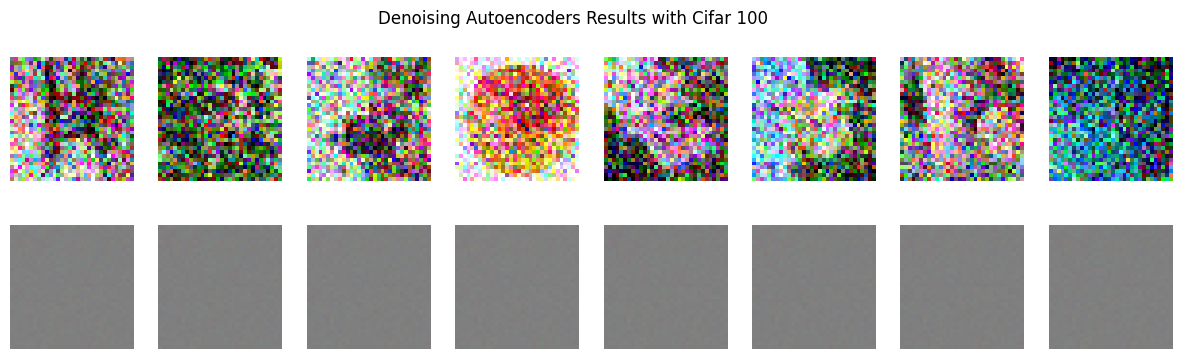

In [56]:
# Cifar 100
noise = 0.3
for epoch in range(num_epochs_):
    denoising_model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer2.zero_grad()
        outputs = denoising_model2(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss2 = denoising_criterion2(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss2.item()
        denoising_optimizer2.zero_grad()
        loss2.backward()
        denoising_optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader2:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model2(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Epoch [1/15], Loss: 0.1405
Epoch [2/15], Loss: 0.1405
Epoch [3/15], Loss: 0.1405
Epoch [4/15], Loss: 0.1405
Epoch [5/15], Loss: 0.1405
Epoch [6/15], Loss: 0.1405
Epoch [7/15], Loss: 0.1405
Epoch [8/15], Loss: 0.1405
Epoch [9/15], Loss: 0.1405
Epoch [10/15], Loss: 0.1405
Epoch [11/15], Loss: 0.1405
Epoch [12/15], Loss: 0.1405
Epoch [13/15], Loss: 0.1405
Epoch [14/15], Loss: 0.1405
Epoch [15/15], Loss: 0.1405


<Figure size 1600x1200 with 0 Axes>

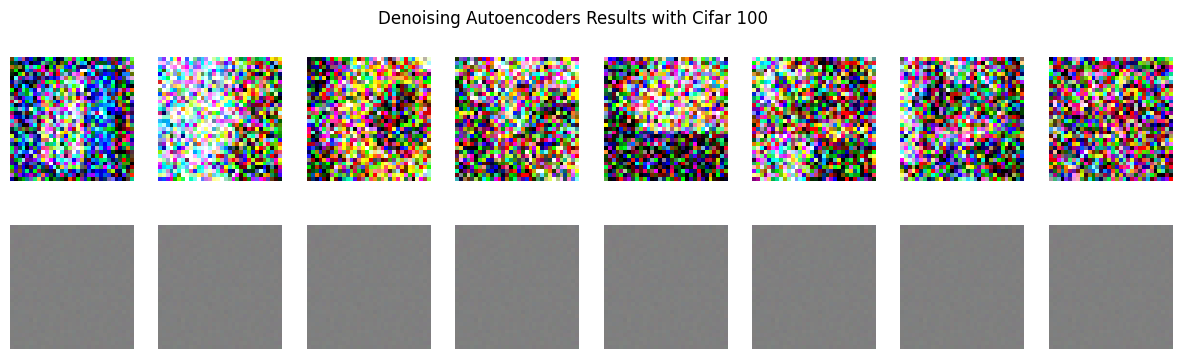

In [57]:
# Cifar 100
noise = 0.5
for epoch in range(num_epochs_):
    denoising_model2.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer2.zero_grad()
        outputs = denoising_model2(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss2 = denoising_criterion2(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss2.item()
        denoising_optimizer2.zero_grad()
        loss2.backward()
        denoising_optimizer2.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

with torch.no_grad():
    for data_c, _ in test_loader2:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model2(data_c)
        break
denoising_recon1 = denoising_recon.view(batch_size_, 3, 32, 32)

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 8, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results with Cifar 100')
for i in range(8):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 5. Anomaly Detection

In [46]:
# Additional hyperparameters
anomaly_sample = 7

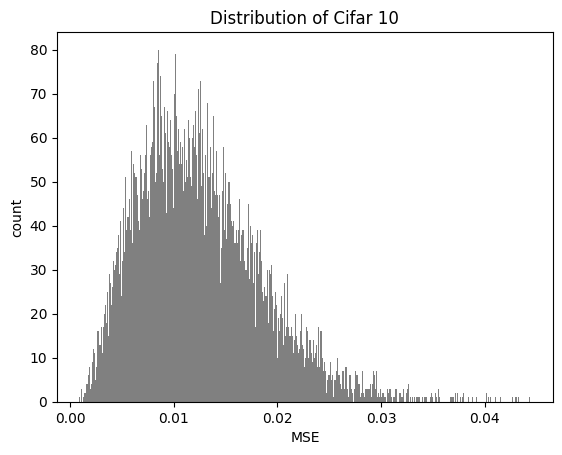

In [47]:
# Cifar 10
all_images = []
anomaly_loss = []
feature_images = []
target_images = []
with torch.no_grad():
    for anomaly_images, _ in test_loader:
        anomaly_images = anomaly_images.to(dev)
        anomaly_recon = model(anomaly_images)
        anomaly_flat_images = anomaly_images.view(anomaly_images.size(0), -1)
        batch_size = anomaly_recon.shape[0]
        for i_batch in range(batch_size):
          i_loss = criterion(anomaly_recon[i_batch],anomaly_flat_images[i_batch]).cpu()
          anomaly_loss.append(i_loss.numpy())
          feature_images.append(anomaly_images[i_batch])
          target_images.append(anomaly_recon[i_batch].view(3, 32, 32))
anomaly_loss = np.array(anomaly_loss)

plt.hist(anomaly_loss, bins=500, color='grey')
plt.title('Distribution of Cifar 10')
plt.xlabel("MSE")
plt.ylabel("count")
plt.show()

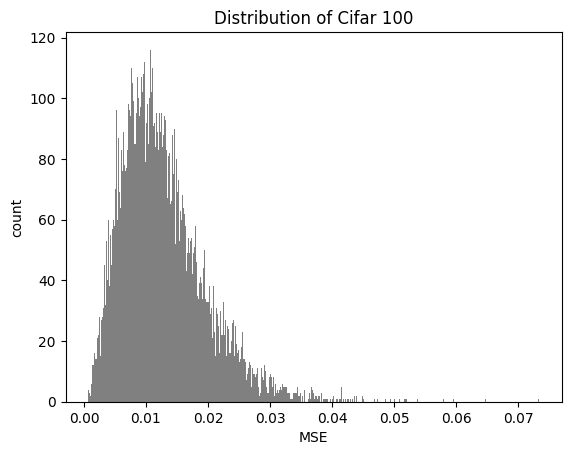

In [58]:
# Cifar 100
all_images = []
anomaly_loss2 = []
feature_images2 = []
target_images2 = []
with torch.no_grad():
    for anomaly_images, _ in test_loader2:
        anomaly_images = anomaly_images.to(dev)
        anomaly_recon = model2(anomaly_images)
        anomaly_flat_images = anomaly_images.view(anomaly_images.size(0), -1)
        batch_size = anomaly_recon.shape[0]
        for i_batch in range(batch_size):
          i_loss = criterion2(anomaly_recon[i_batch],anomaly_flat_images[i_batch]).cpu()
          anomaly_loss2.append(i_loss.numpy())
          feature_images2.append(anomaly_images[i_batch])
          target_images2.append(anomaly_recon[i_batch].view(3, 32, 32))
anomaly_loss2 = np.array(anomaly_loss2)

plt.hist(anomaly_loss2, bins=500, color='grey')
plt.title('Distribution of Cifar 100')
plt.xlabel("MSE")
plt.ylabel("count")
plt.show()

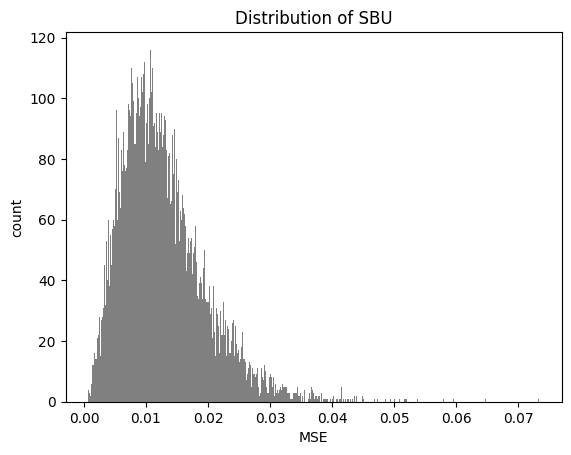

In [71]:
# SBU
all_images = []
anomaly_loss3 = []
feature_images3 = []
target_images3 = []
with torch.no_grad():
    for anomaly_images, _ in test_loader2:
        anomaly_images = anomaly_images.to(dev)
        anomaly_recon = model3(anomaly_images)
        anomaly_flat_images = anomaly_images.view(anomaly_images.size(0), -1)
        batch_size = anomaly_recon.shape[0]
        for i_batch in range(batch_size):
          i_loss = criterion3(anomaly_recon[i_batch],anomaly_flat_images[i_batch]).cpu()
          anomaly_loss3.append(i_loss.numpy())
          feature_images3.append(anomaly_images[i_batch])
          target_images3.append(anomaly_recon[i_batch].view(3, 32, 32))
anomaly_loss3 = np.array(anomaly_loss2)

plt.hist(anomaly_loss3, bins=500, color='grey')
plt.title('Distribution of SBU')
plt.xlabel("MSE")
plt.ylabel("count")
plt.show()

<Figure size 1600x1200 with 0 Axes>

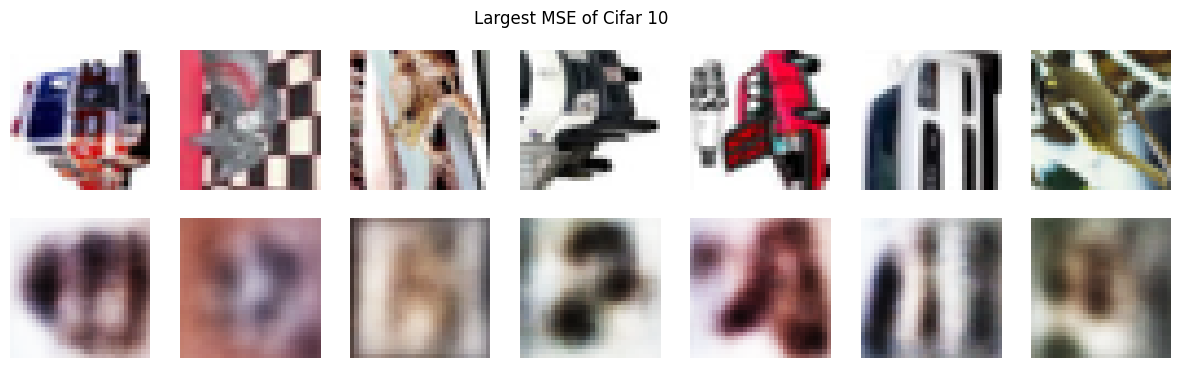

In [49]:
# Cifar 10
anomalies_indx = np.argsort(anomaly_loss)[-anomaly_sample:]
plt.figure(dpi=250)
fig, ax = plt.subplots(2, anomaly_sample, figsize=(15, 4))
fig.suptitle('Largest MSE of Cifar 10')
for i in range(anomaly_sample):
    ax[0, i].imshow(feature_images[anomalies_indx[i]].cpu().numpy().T)
    ax[1, i].imshow(target_images[anomalies_indx[i]].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

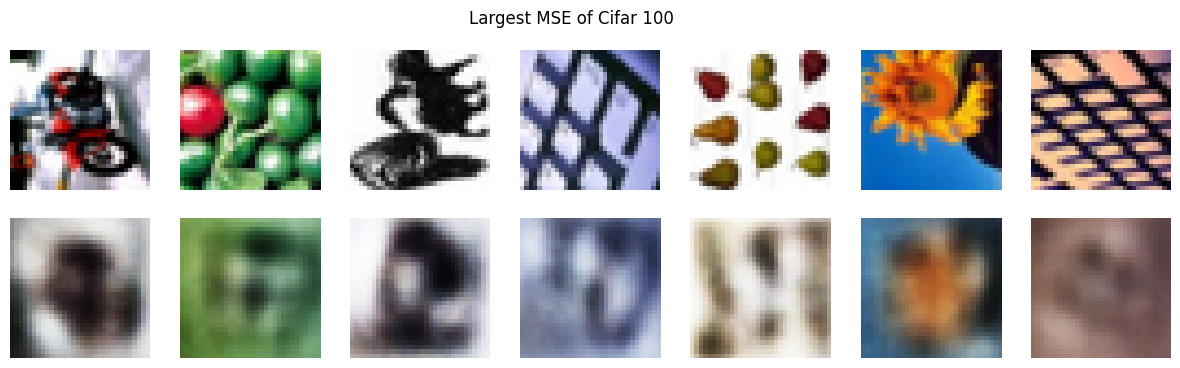

In [59]:
# Cifar 100
anomalies_indx = np.argsort(anomaly_loss2)[-anomaly_sample:]
plt.figure(dpi=250)
fig, ax = plt.subplots(2, anomaly_sample, figsize=(15, 4))
fig.suptitle('Largest MSE of Cifar 100')
for i in range(anomaly_sample):
    ax[0, i].imshow(feature_images2[anomalies_indx[i]].cpu().numpy().T)
    ax[1, i].imshow(target_images2[anomalies_indx[i]].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

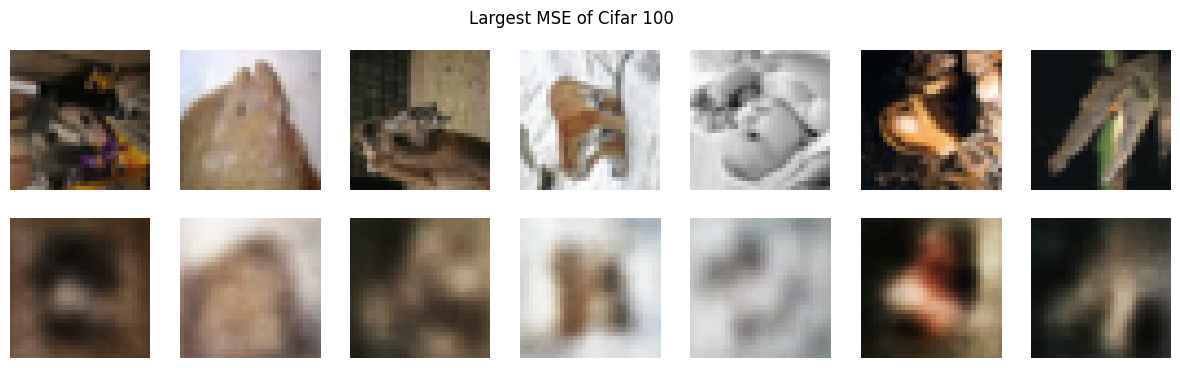

In [72]:
# SBU
anomalies_indx = np.argsort(anomaly_loss3)[-anomaly_sample:]
plt.figure(dpi=250)
fig, ax = plt.subplots(2, anomaly_sample, figsize=(15, 4))
fig.suptitle('Largest MSE of Cifar 100')
for i in range(anomaly_sample):
    ax[0, i].imshow(feature_images3[anomalies_indx[i]].cpu().numpy().T)
    ax[1, i].imshow(target_images3[anomalies_indx[i]].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()